In [184]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

In [185]:
# Read the CSV file
columns  = ["polarity", "id", "date", "flag", "user", "text"]
encode = "ISO-8859-1"
s140 = pd.read_csv("../data/training.1600000.processed.noemoticon.csv",  encoding=encode , names=columns)
s140.drop(columns=['id', 'flag', 'user'], inplace=True)

display(s140.head())

# Convert the date column to datetime and UTC timezone
s140['date'] = s140['date'].str.replace(" PDT", "")
s140['date'] = pd.to_datetime(s140['date'], format="%a %b %d %H:%M:%S %Y")
s140['date'] = s140['date'] + pd.Timedelta(hours=7)
s140['date'] = s140['date'].dt.strftime("%Y-%m-%d %H:%M:%S")
s140['date'] = pd.to_datetime(s140['date'])

s140['polarity'] = s140['polarity'].replace(4,1)

# Print the dataframe and its infos
display(s140.info(verbose=True, show_counts=True))
s140.head()

polarity                          date  \
0         0  Mon Apr 06 22:19:45 PDT 2009   
1         0  Mon Apr 06 22:19:49 PDT 2009   
2         0  Mon Apr 06 22:19:53 PDT 2009   
3         0  Mon Apr 06 22:19:57 PDT 2009   
4         0  Mon Apr 06 22:19:57 PDT 2009   

                                                text  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   polarity  1600000 non-null  int64         
 1   date      1600000 non-null  datetime64[ns]
 2   text      1600000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 36.6+ MB


None

polarity                date  \
0         0 2009-04-07 05:19:45   
1         0 2009-04-07 05:19:49   
2         0 2009-04-07 05:19:53   
3         0 2009-04-07 05:19:57   
4         0 2009-04-07 05:19:57   

                                                text  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....

In [186]:
s140.polarity.value_counts()

0    800000
1    800000
Name: polarity, dtype: int64

In [187]:
data_pos = s140[s140['polarity'] == 1]
data_neg = s140[s140['polarity'] == 0]

data_pos = data_pos.iloc[:int(100000)]
data_neg = data_neg.iloc[:int(100000)]

df = pd.concat([data_pos, data_neg])

## Limpeza dos textos
Remover:
- stopwords
- emojis (o dataset de treino não possui, mas o de validação sim)
- urls
- pontuação

In [188]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [189]:
def text_preprocessing(text):
    
    """ converting text to lower case """
    text = text.lower()
    
    for emoji in emojis.keys():
        text = text.replace(emoji, "emoji:" + emojis[emoji])
    
    """ replace the urls to URL """
    text = re.sub("http:\S+|www.\S", "URL", text)
    
    """ removing the punctuations """
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    """ stopwords removal """
    STOPWORDS = set(stopwords.words('english'))
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])

    """ tokenization """
    tokenizer = RegexpTokenizer(r'\w+|$[0-9]+|\S+')
    text = " ".join(tokenizer.tokenize(text))
    
    """ lemmatization """
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in str(text).split()])
    
    """ stemming """
    st = PorterStemmer()
    text = " ".join([st.stem(word) for word in str(text).split()])
    
    return text

In [190]:
%%time
df["original_length"] = df["text"].apply(len)
df["text_processed"] = df["text"].apply(lambda text : text_preprocessing(text))
df.head()

CPU times: user 1min 18s, sys: 3.13 s, total: 1min 21s
Wall time: 1min 21s


polarity                date  \
800000         1 2009-04-07 05:22:45   
800001         1 2009-04-07 05:22:45   
800002         1 2009-04-07 05:22:46   
800003         1 2009-04-07 05:22:46   
800004         1 2009-04-07 05:22:46   

                                                     text  original_length  \
800000       I LOVE @Health4UandPets u guys r the best!!                44   
800001  im meeting up with one of my besties tonight! ...               72   
800002  @DaRealSunisaKim Thanks for the Twitter add, S...              137   
800003  Being sick can be really cheap when it hurts t...              104   
800004    @LovesBrooklyn2 he has that effect on everyone                47   

                                           text_processed  
800000                   love health4uandpet u guy r best  
800001      im meet one besti tonight cant wait girl talk  
800002  darealsunisakim thank twitter add sunisa got m...  
800003  sick realli cheap hurt much eat real food plu ...  
800004                      lovesbrooklyn2 effect everyon

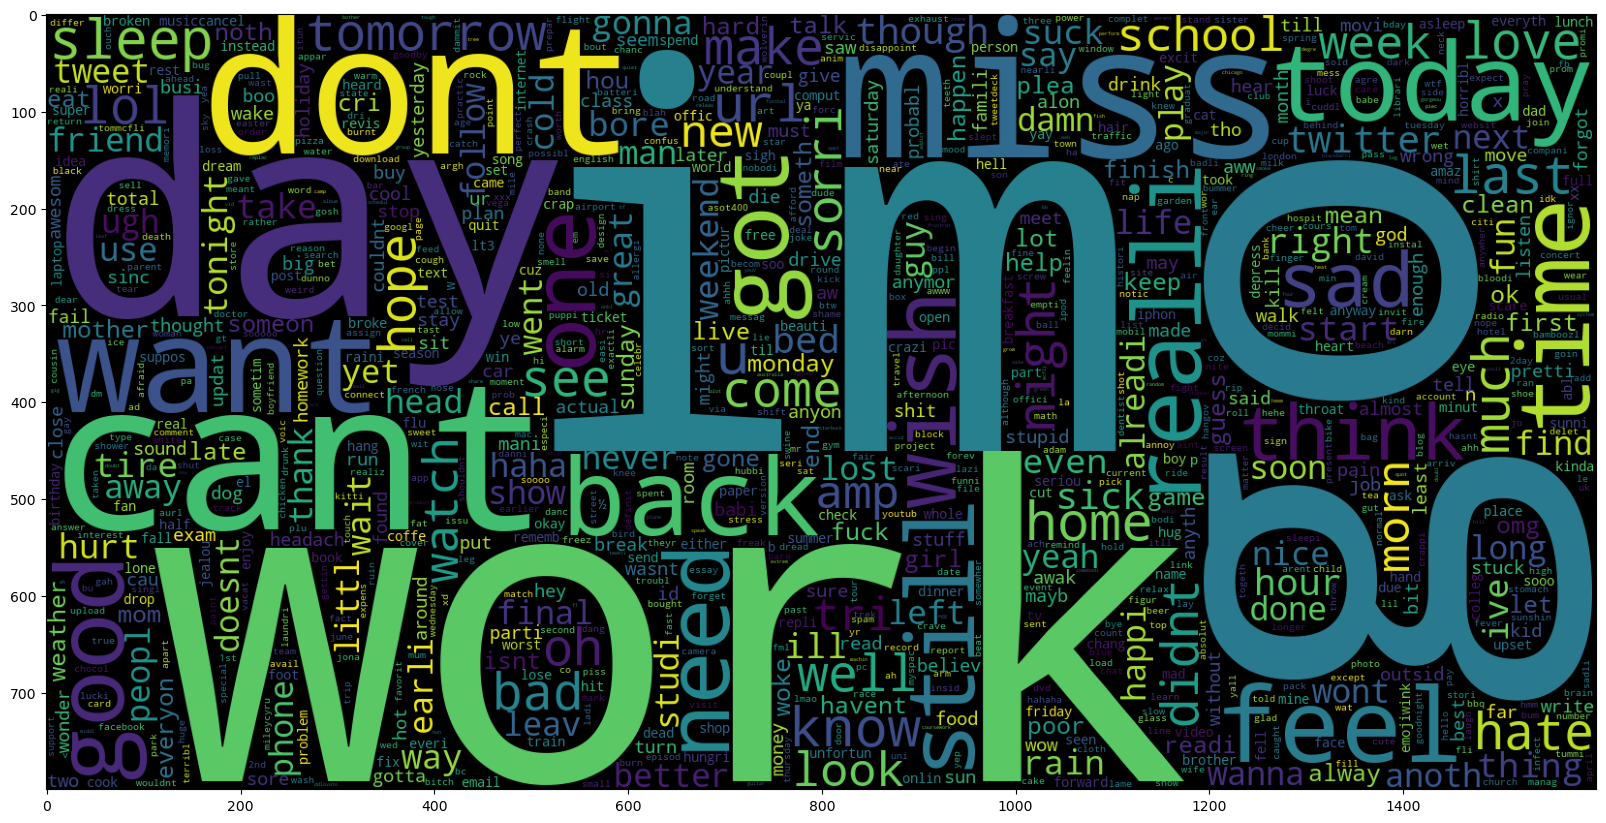

In [191]:
data_neg = df.query('polarity==0')['text_processed']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

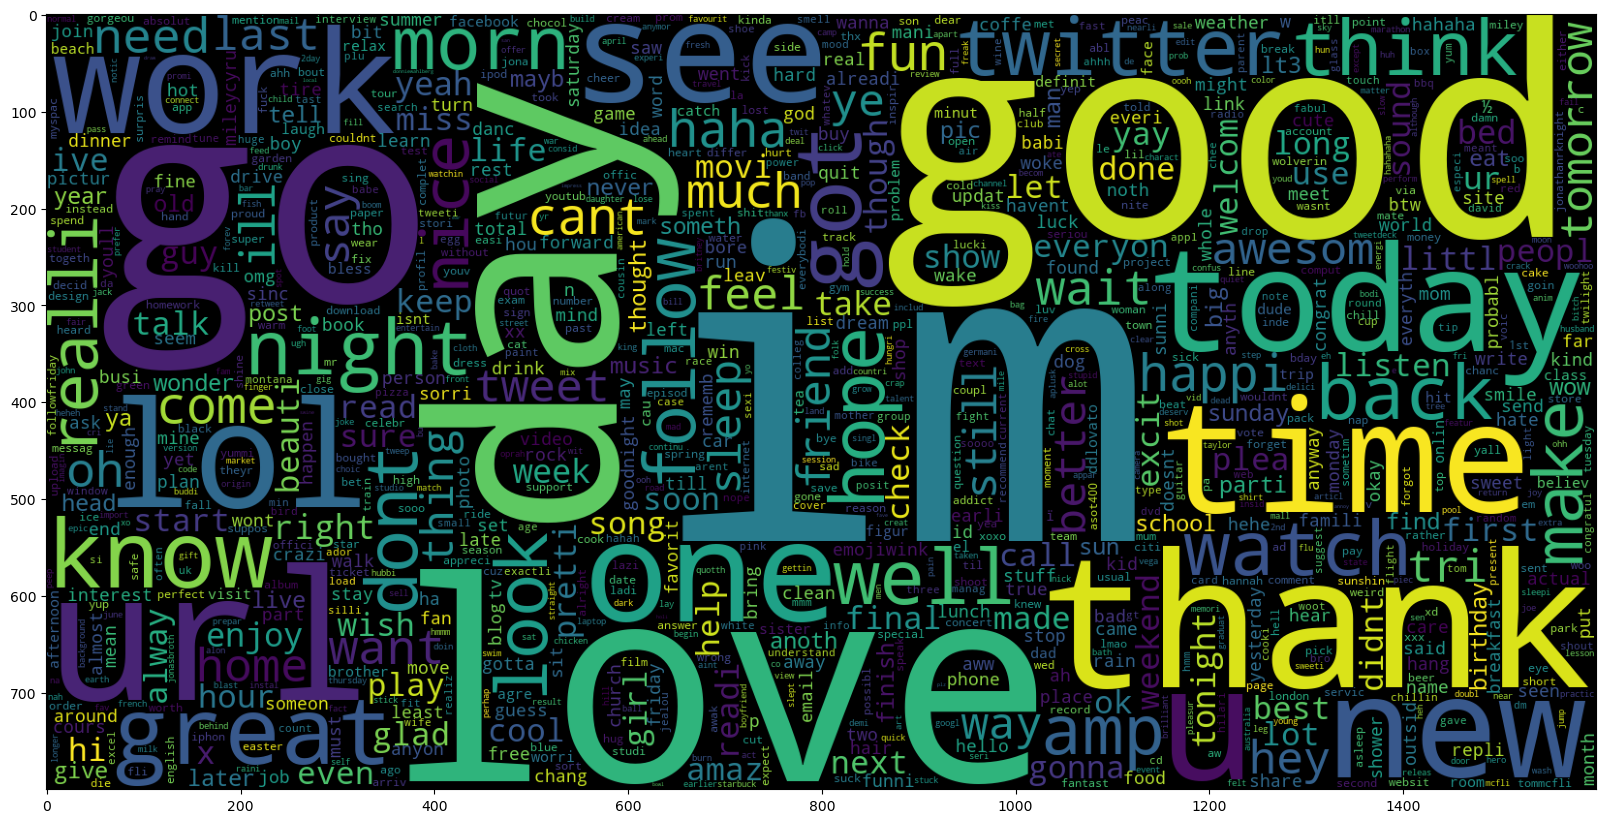

In [192]:
data_pos = df.query('polarity==1')['text_processed']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

In [193]:
X=df.text_processed
y=df.polarity

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 49)

In [194]:
X_train

85897     get readi take zed weekend pediatr clinic poor...
825471    time let guard open amp let realiz mayb he one...
96517     plant loos leaf like crazi although pot big en...
70540                    addict madden need profession help
99854                                    scottywu aint good
                                ...                        
807924                      phillipgibb yup get system haha
819638                         ludajuic url she sooooo cute
881397                         bam808 ye screw twitter alot
86029           sharlynnx go bed soon haha school tomoro xx
800426    jennma awesom home work around 430 take puppi ...
Name: text_processed, Length: 150000, dtype: object

In [195]:
vectorizer_1_3_gram = TfidfVectorizer(ngram_range=(1,3))
vectorizer_1_3_gram.fit(X_train)

TfidfVectorizer(ngram_range=(1, 3))

In [196]:
vectorizer_1_2_gram = TfidfVectorizer(ngram_range=(1,2))
vectorizer_1_2_gram.fit(X_train)

TfidfVectorizer(ngram_range=(1, 2))

In [197]:
vectorizer_2_3_gram = TfidfVectorizer(ngram_range=(2,3))
vectorizer_2_3_gram.fit(X_train)

TfidfVectorizer(ngram_range=(2, 3))

In [198]:
vectorizer_1_gram = TfidfVectorizer(ngram_range=(1,1))
vectorizer_1_gram.fit(X_train)

TfidfVectorizer()

In [199]:
vectorizer_2_gram = TfidfVectorizer(ngram_range=(2,2))
vectorizer_2_gram.fit(X_train)

TfidfVectorizer(ngram_range=(2, 2))

In [200]:
vectorizer_3_gram = TfidfVectorizer(ngram_range=(3,3))
vectorizer_3_gram.fit(X_train)

TfidfVectorizer(ngram_range=(3, 3))

In [201]:
X_train_1_3_gram = vectorizer_1_3_gram.transform(X_train)
X_test_1_3_gram  = vectorizer_1_3_gram.transform(X_test)

In [202]:
X_train_1_2_gram = vectorizer_1_2_gram.transform(X_train)
X_test_1_2_gram  = vectorizer_1_2_gram.transform(X_test)

In [203]:
X_train_2_3_gram = vectorizer_2_3_gram.transform(X_train)
X_test_2_3_gram  = vectorizer_2_3_gram.transform(X_test)

In [204]:
X_train_1_gram = vectorizer_1_gram.transform(X_train)
X_test_1_gram  = vectorizer_1_gram.transform(X_test)

In [205]:
X_train_2_gram = vectorizer_2_gram.transform(X_train)
X_test_2_gram  = vectorizer_2_gram.transform(X_test)

In [206]:
X_train_3_gram = vectorizer_3_gram.transform(X_train)
X_test_3_gram  = vectorizer_3_gram.transform(X_test)

In [207]:
results_df = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

In [208]:
def model_Evaluate(model, fpr, tpr, y_test, y_pred):
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg ','False Pos ', 'False Neg ','True Pos ']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1} {v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Return metrics as a dictionary
    metrics_dict = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': roc_auc
    }

    return metrics_dict

              precision    recall  f1-score   support

           0       0.77      0.77      0.77     25052
           1       0.77      0.76      0.77     24948

    accuracy                           0.77     50000
   macro avg       0.77      0.77      0.77     50000
weighted avg       0.77      0.77      0.77     50000



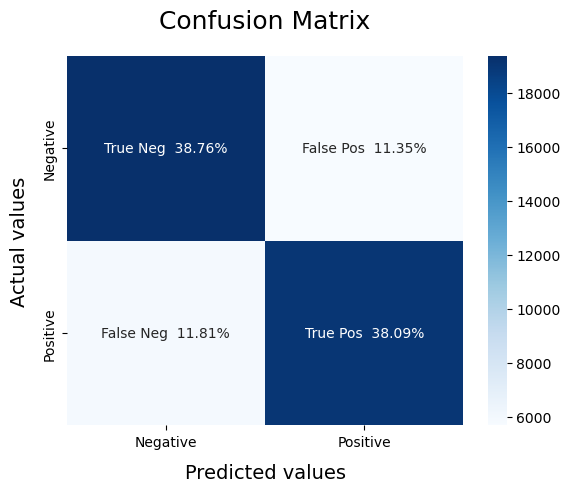

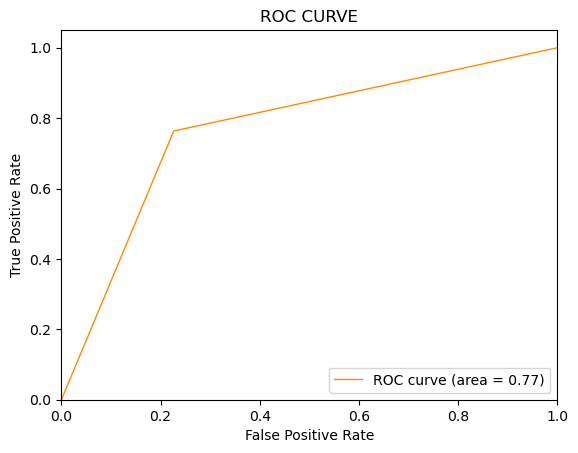

CPU times: user 1.05 s, sys: 300 ms, total: 1.35 s
Wall time: 988 ms


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [209]:
%%time
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_1_3_gram, y_train)
y_pred1 = BNBmodel.predict(X_test_1_3_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
metrics_dict = model_Evaluate(BNBmodel, fpr, tpr, y_test, y_pred1)

results_df = results_df.append({'Model': 'BernoulliNB', 'Dataset': 'X_train_1_3_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.77      0.80      0.79     25052
           1       0.79      0.76      0.78     24948

    accuracy                           0.78     50000
   macro avg       0.78      0.78      0.78     50000
weighted avg       0.78      0.78      0.78     50000



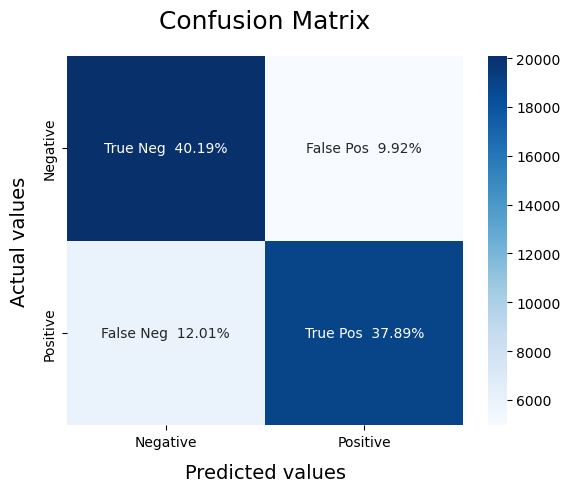

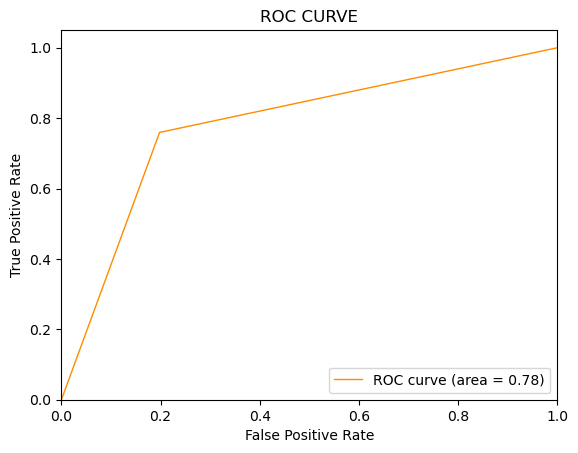

CPU times: user 3.81 s, sys: 316 ms, total: 4.13 s
Wall time: 3.77 s


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [210]:
%%time
SVCmodel = LinearSVC(dual='auto')
SVCmodel.fit(X_train_1_3_gram, y_train)
y_pred2 = SVCmodel.predict(X_test_1_3_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
metrics_dict = model_Evaluate(SVCmodel, fpr, tpr, y_test, y_pred2)

results_df = results_df.append({'Model': 'LinearSVC', 'Dataset': 'X_train_1_3_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.77      0.79      0.78     25052
           1       0.79      0.76      0.77     24948

    accuracy                           0.78     50000
   macro avg       0.78      0.78      0.78     50000
weighted avg       0.78      0.78      0.78     50000



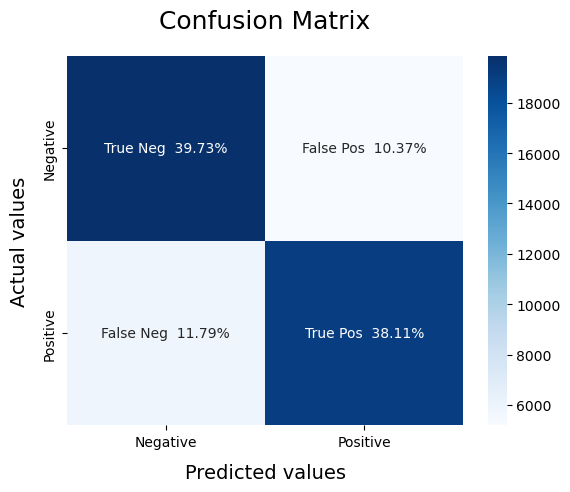

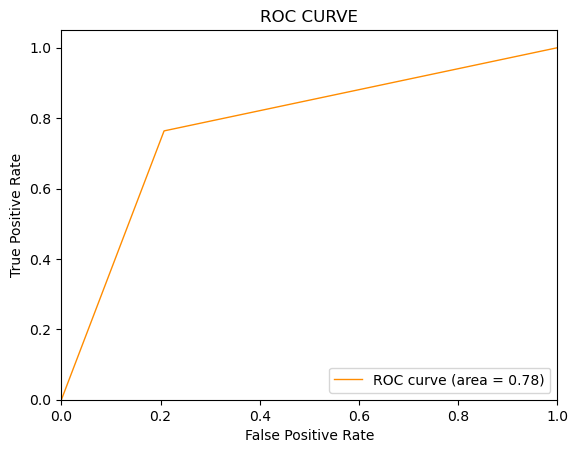

CPU times: user 1.18 s, sys: 679 ms, total: 1.85 s
Wall time: 53 s


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [211]:
%%time
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train_1_3_gram, y_train)
y_pred3 = LRmodel.predict(X_test_1_3_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
metrics_dict = model_Evaluate(LRmodel, fpr, tpr, y_test, y_pred3)

results_df = results_df.append({'Model': 'LogisticRegression', 'Dataset': 'X_train_1_3_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.75      0.78      0.77     25052
           1       0.77      0.74      0.75     24948

    accuracy                           0.76     50000
   macro avg       0.76      0.76      0.76     50000
weighted avg       0.76      0.76      0.76     50000



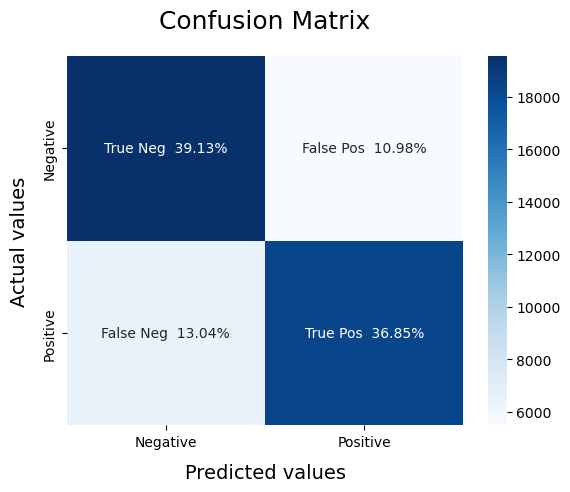

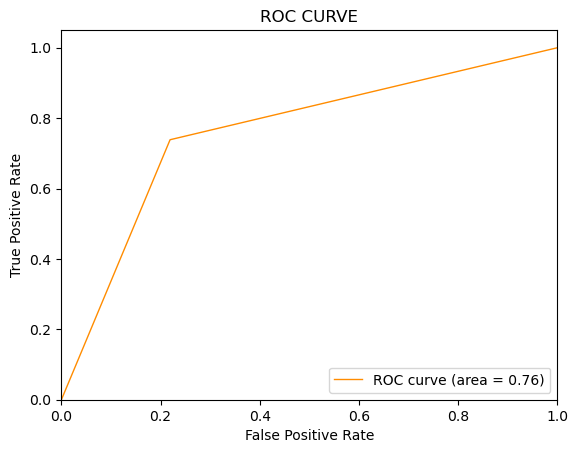

CPU times: user 11h 53min 40s, sys: 49.3 s, total: 11h 54min 29s
Wall time: 3h 20s


<timed exec>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [212]:
%%time
RFmodel = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=49,
    n_jobs=-1
)
RFmodel.fit(X_train_1_3_gram, y_train)
y_pred4 = RFmodel.predict(X_test_1_3_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred4)
metrics_dict = model_Evaluate(RFmodel, fpr, tpr, y_test, y_pred4)

results_df = results_df.append({'Model': 'RandomForestClassifier1', 'Dataset': 'X_train_1_3_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.75      0.78      0.77     25052
           1       0.77      0.74      0.76     24948

    accuracy                           0.76     50000
   macro avg       0.76      0.76      0.76     50000
weighted avg       0.76      0.76      0.76     50000



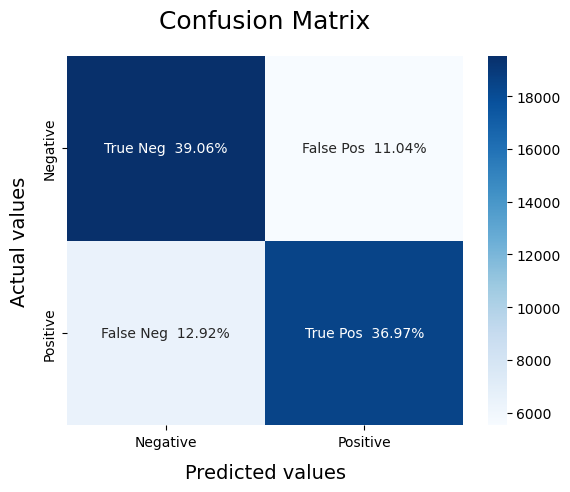

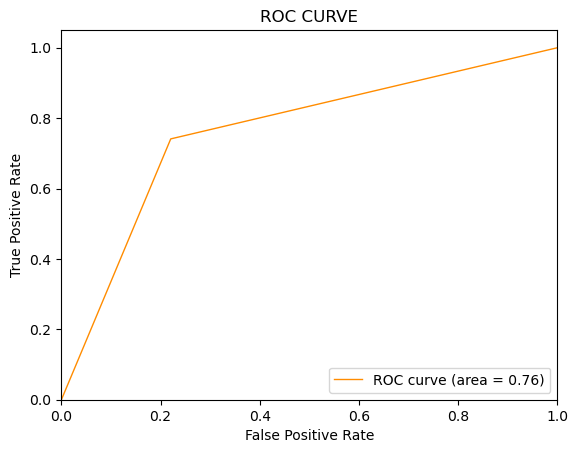

CPU times: user 11h 45min 28s, sys: 46.5 s, total: 11h 46min 15s
Wall time: 2h 58min 17s


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [213]:
%%time
RFmodel = RandomForestClassifier(
    n_jobs=-1
)
RFmodel.fit(X_train_1_3_gram, y_train)
y_pred5 = RFmodel.predict(X_test_1_3_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred5)
metrics_dict = model_Evaluate(RFmodel, fpr, tpr, y_test, y_pred5)

results_df = results_df.append({'Model': 'RandomForestClassifier2', 'Dataset': 'X_train_1_3_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.76      0.79      0.77     25052
           1       0.78      0.75      0.76     24948

    accuracy                           0.77     50000
   macro avg       0.77      0.77      0.77     50000
weighted avg       0.77      0.77      0.77     50000



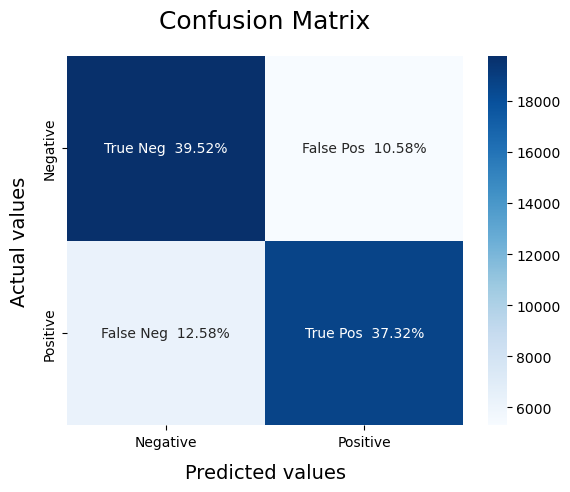

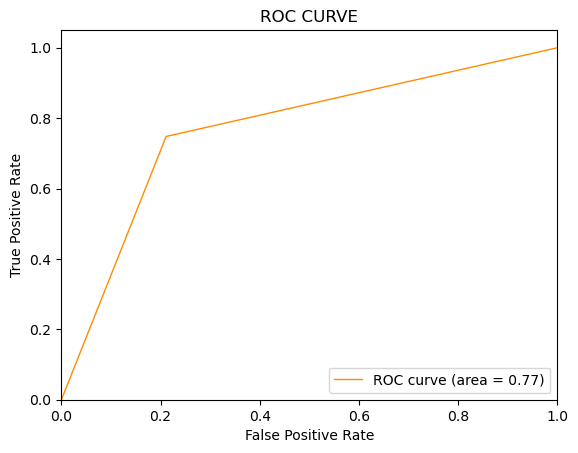

CPU times: user 1.06 s, sys: 200 ms, total: 1.26 s
Wall time: 884 ms


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [214]:
%%time
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_1_2_gram, y_train)
y_pred1 = BNBmodel.predict(X_test_1_2_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
metrics_dict = model_Evaluate(BNBmodel, fpr, tpr, y_test, y_pred1)

results_df = results_df.append({'Model': 'BernoulliNB', 'Dataset': 'X_train_1_2_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.78      0.79      0.78     25052
           1       0.78      0.77      0.78     24948

    accuracy                           0.78     50000
   macro avg       0.78      0.78      0.78     50000
weighted avg       0.78      0.78      0.78     50000



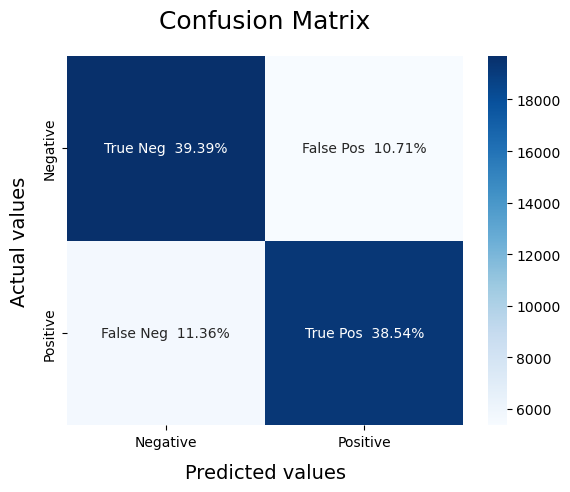

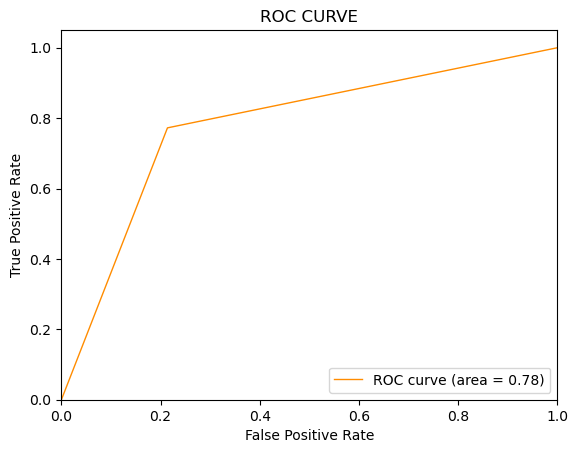

CPU times: user 3.44 s, sys: 230 ms, total: 3.67 s
Wall time: 3.3 s


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [215]:
%%time
SVCmodel = LinearSVC(dual='auto')
SVCmodel.fit(X_train_1_2_gram, y_train)
y_pred2 = SVCmodel.predict(X_test_1_2_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
metrics_dict = model_Evaluate(SVCmodel, fpr, tpr, y_test, y_pred2)

results_df = results_df.append({'Model': 'LinearSVC', 'Dataset': 'X_train_1_2_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78     25052
           1       0.78      0.78      0.78     24948

    accuracy                           0.78     50000
   macro avg       0.78      0.78      0.78     50000
weighted avg       0.78      0.78      0.78     50000



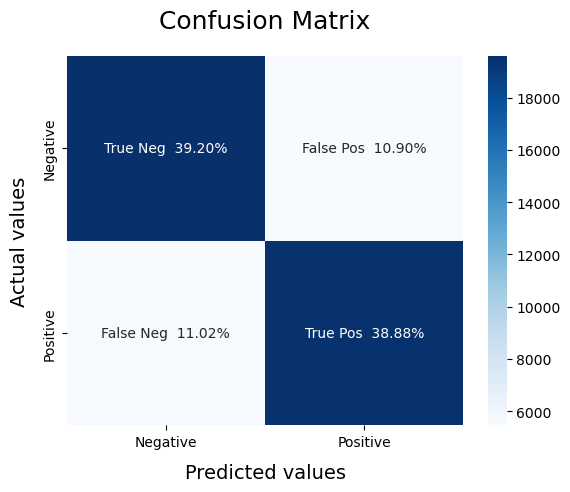

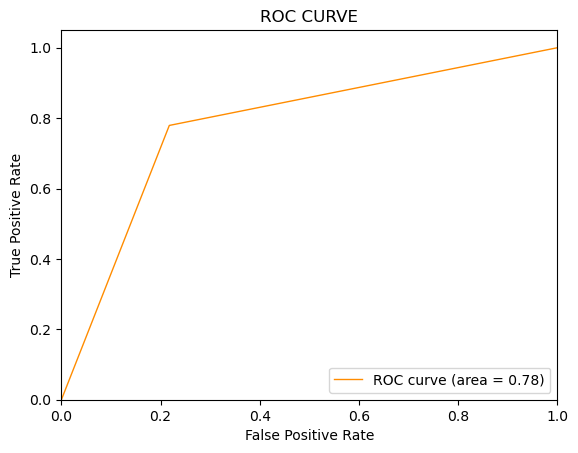

CPU times: user 1.01 s, sys: 529 ms, total: 1.54 s
Wall time: 12 s


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [216]:
%%time
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train_1_2_gram, y_train)
y_pred3 = LRmodel.predict(X_test_1_2_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
metrics_dict = model_Evaluate(LRmodel, fpr, tpr, y_test, y_pred3)

results_df = results_df.append({'Model': 'LogisticRegression', 'Dataset': 'X_train_1_2_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.76      0.78      0.77     25052
           1       0.77      0.75      0.76     24948

    accuracy                           0.76     50000
   macro avg       0.76      0.76      0.76     50000
weighted avg       0.76      0.76      0.76     50000



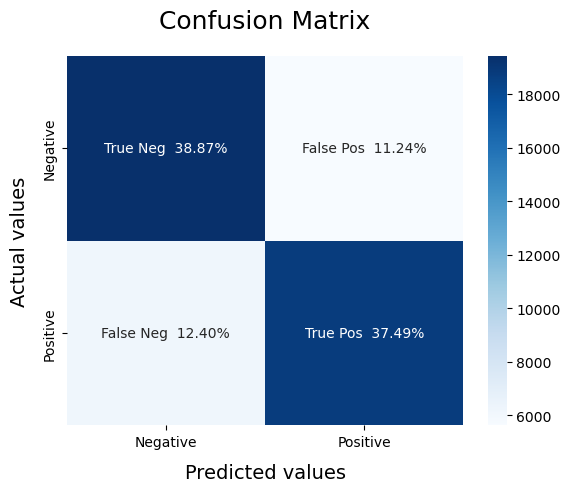

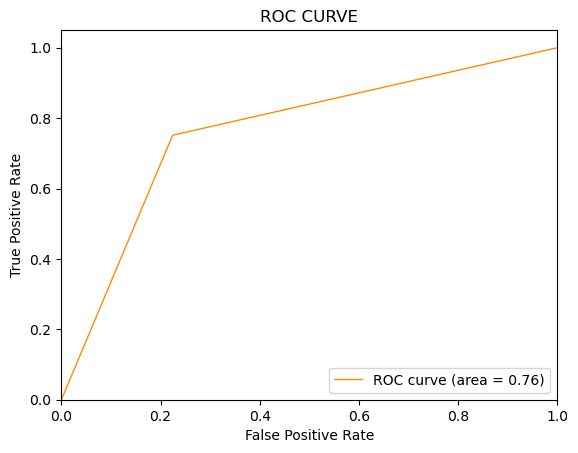

CPU times: user 6h 40min 3s, sys: 28.3 s, total: 6h 40min 32s
Wall time: 1h 41min 35s


<timed exec>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [217]:
%%time
RFmodel = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=49,
    n_jobs=-1
)
RFmodel.fit(X_train_1_2_gram, y_train)
y_pred4 = RFmodel.predict(X_test_1_2_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred4)
metrics_dict = model_Evaluate(RFmodel, fpr, tpr, y_test, y_pred4)

results_df = results_df.append({'Model': 'RandomForestClassifier1', 'Dataset': 'X_train_1_2_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.76      0.78      0.77     25052
           1       0.77      0.75      0.76     24948

    accuracy                           0.76     50000
   macro avg       0.76      0.76      0.76     50000
weighted avg       0.76      0.76      0.76     50000



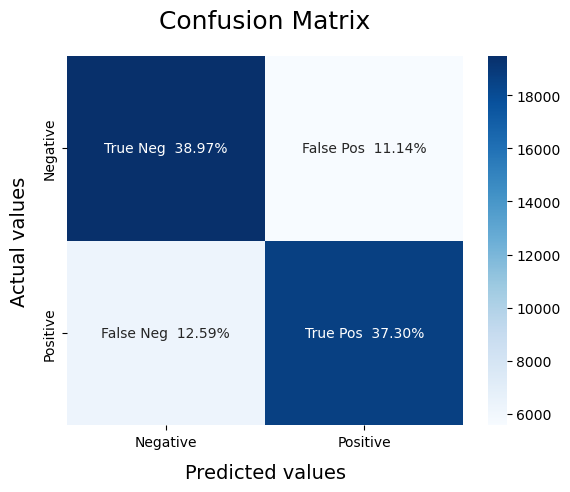

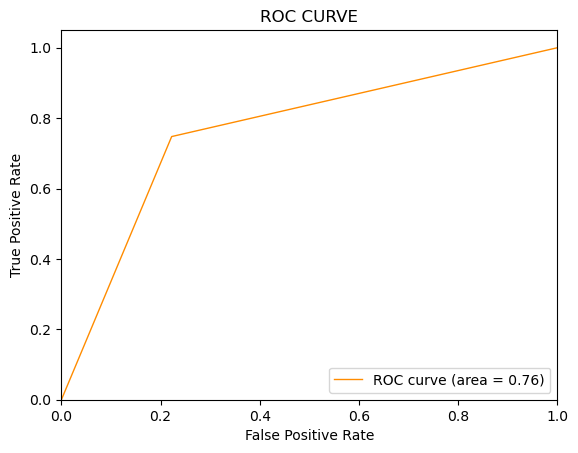

CPU times: user 6h 26min 10s, sys: 25.6 s, total: 6h 26min 35s
Wall time: 1h 37min 35s


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [218]:
%%time
RFmodel = RandomForestClassifier(
    n_jobs=-1
)
RFmodel.fit(X_train_1_2_gram, y_train)
y_pred5 = RFmodel.predict(X_test_1_2_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred5)
metrics_dict = model_Evaluate(RFmodel, fpr, tpr, y_test, y_pred5)

results_df = results_df.append({'Model': 'RandomForestClassifier2', 'Dataset': 'X_train_1_2_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.73      0.64      0.68     25052
           1       0.68      0.77      0.72     24948

    accuracy                           0.70     50000
   macro avg       0.71      0.70      0.70     50000
weighted avg       0.71      0.70      0.70     50000



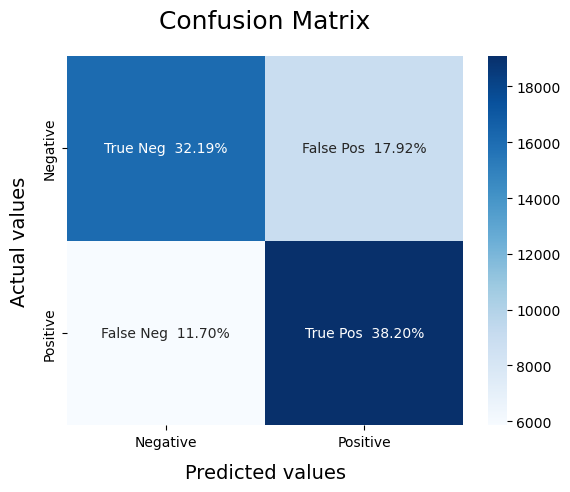

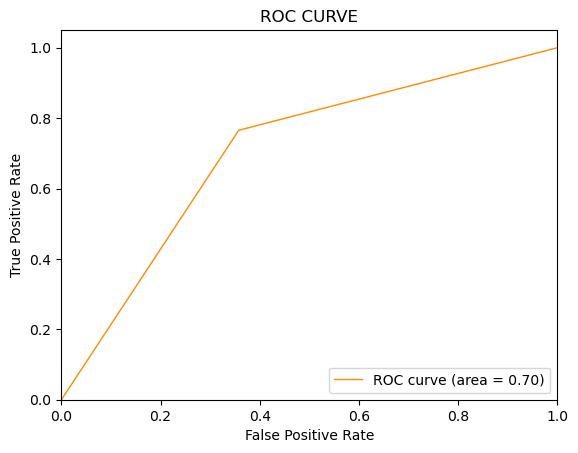

CPU times: user 1.1 s, sys: 210 ms, total: 1.31 s
Wall time: 938 ms


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [219]:
%%time
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_2_3_gram, y_train)
y_pred1 = BNBmodel.predict(X_test_2_3_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
metrics_dict = model_Evaluate(BNBmodel, fpr, tpr, y_test, y_pred1)

results_df = results_df.append({'Model': 'BernoulliNB', 'Dataset': 'X_train_2_3_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.73      0.65      0.69     25052
           1       0.68      0.76      0.72     24948

    accuracy                           0.70     50000
   macro avg       0.71      0.70      0.70     50000
weighted avg       0.71      0.70      0.70     50000



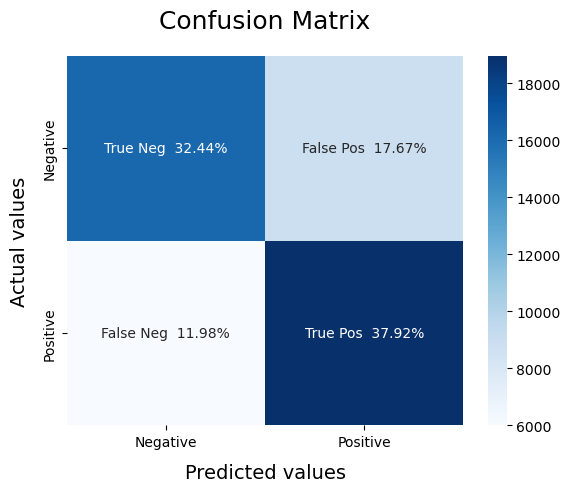

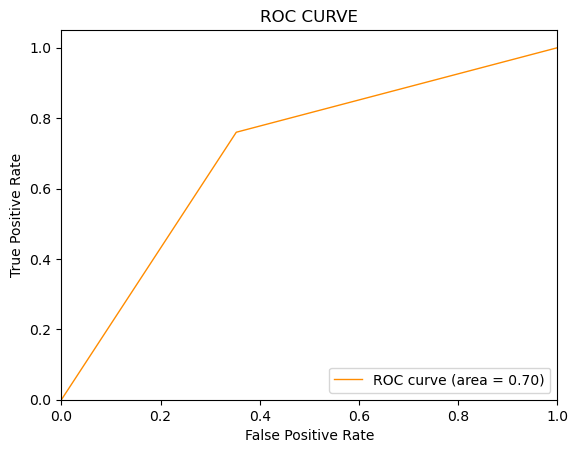

CPU times: user 3.8 s, sys: 220 ms, total: 4.02 s
Wall time: 3.65 s


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [220]:
%%time
SVCmodel = LinearSVC(dual='auto')
SVCmodel.fit(X_train_2_3_gram, y_train)
y_pred2 = SVCmodel.predict(X_test_2_3_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
metrics_dict = model_Evaluate(SVCmodel, fpr, tpr, y_test, y_pred2)

results_df = results_df.append({'Model': 'LinearSVC', 'Dataset': 'X_train_2_3_gram', **metrics_dict}, ignore_index=True)

In [221]:
%%time
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train_2_3_gram, y_train)
y_pred3 = LRmodel.predict(X_test_2_3_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
metrics_dict = model_Evaluate(LRmodel, fpr, tpr, y_test, y_pred3)

results_df = results_df.append({'Model': 'LogisticRegression', 'Dataset': 'X_train_2_3_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.74      0.64      0.68     25052
           1       0.68      0.77      0.72     24948

    accuracy                           0.71     50000
   macro avg       0.71      0.71      0.70     50000
weighted avg       0.71      0.71      0.70     50000



CPU times: user 846 ms, sys: 509 ms, total: 1.36 s
Wall time: 35.1 s


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


              precision    recall  f1-score   support

           0       0.61      0.81      0.70     25052
           1       0.72      0.49      0.58     24948

    accuracy                           0.65     50000
   macro avg       0.67      0.65      0.64     50000
weighted avg       0.67      0.65      0.64     50000



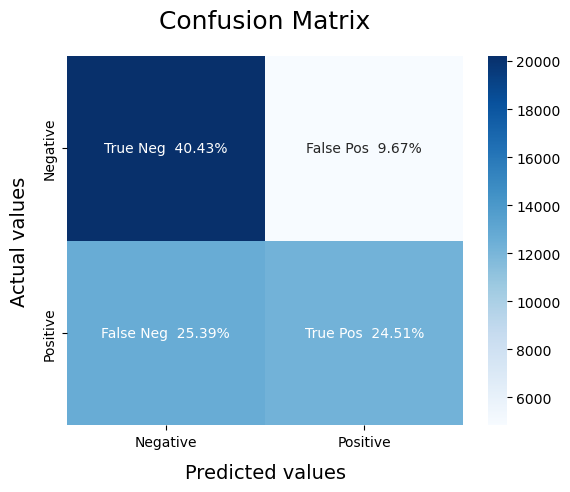

CPU times: user 15h 41min 6s, sys: 1min 17s, total: 15h 42min 23s
Wall time: 3h 59min 30s


<timed exec>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [222]:
%%time
RFmodel = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=49,
    n_jobs=-1
)
RFmodel.fit(X_train_2_3_gram, y_train)
y_pred4 = RFmodel.predict(X_test_2_3_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred4)
metrics_dict = model_Evaluate(RFmodel, fpr, tpr, y_test, y_pred4)

results_df = results_df.append({'Model': 'RandomForestClassifier1', 'Dataset': 'X_train_2_3_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.61      0.80      0.70     25052
           1       0.72      0.49      0.58     24948

    accuracy                           0.65     50000
   macro avg       0.66      0.65      0.64     50000
weighted avg       0.66      0.65      0.64     50000



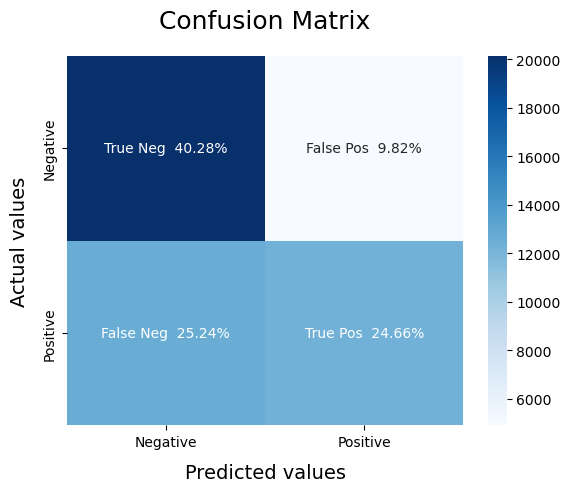

CPU times: user 15h 23min 30s, sys: 1min 16s, total: 15h 24min 47s
Wall time: 3h 54min 21s


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [223]:
%%time
RFmodel = RandomForestClassifier(
    n_jobs=-1
)
RFmodel.fit(X_train_2_3_gram, y_train)
y_pred5 = RFmodel.predict(X_test_2_3_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred5)
metrics_dict = model_Evaluate(RFmodel, fpr, tpr, y_test, y_pred5)

results_df = results_df.append({'Model': 'RandomForestClassifier2', 'Dataset': 'X_train_2_3_gram', **metrics_dict}, ignore_index=True)

In [224]:
%%time
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_1_gram, y_train)
y_pred1 = BNBmodel.predict(X_test_1_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
metrics_dict = model_Evaluate(BNBmodel, fpr, tpr, y_test, y_pred1)

results_df = results_df.append({'Model': 'BernoulliNB', 'Dataset': 'X_train_1_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.74      0.79      0.77     25052
           1       0.78      0.73      0.75     24948

    accuracy                           0.76     50000
   macro avg       0.76      0.76      0.76     50000
weighted avg       0.76      0.76      0.76     50000



CPU times: user 901 ms, sys: 210 ms, total: 1.11 s
Wall time: 746 ms


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


              precision    recall  f1-score   support

           0       0.76      0.76      0.76     25052
           1       0.76      0.77      0.76     24948

    accuracy                           0.76     50000
   macro avg       0.76      0.76      0.76     50000
weighted avg       0.76      0.76      0.76     50000



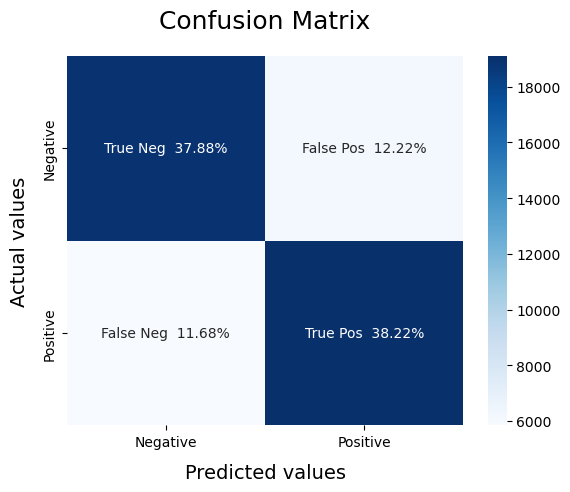

CPU times: user 13.6 s, sys: 9.43 s, total: 23 s
Wall time: 6.22 s


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [225]:
%%time
SVCmodel = LinearSVC(dual='auto')
SVCmodel.fit(X_train_1_gram, y_train)
y_pred2 = SVCmodel.predict(X_test_1_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
metrics_dict = model_Evaluate(SVCmodel, fpr, tpr, y_test, y_pred2)

results_df = results_df.append({'Model': 'LinearSVC', 'Dataset': 'X_train_1_gram', **metrics_dict}, ignore_index=True)

In [226]:
%%time
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train_1_gram, y_train)
y_pred3 = LRmodel.predict(X_test_1_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
metrics_dict = model_Evaluate(LRmodel, fpr, tpr, y_test, y_pred3)

results_df = results_df.append({'Model': 'LogisticRegression', 'Dataset': 'X_train_1_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.78      0.76      0.77     25052
           1       0.76      0.78      0.77     24948

    accuracy                           0.77     50000
   macro avg       0.77      0.77      0.77     50000
weighted avg       0.77      0.77      0.77     50000



CPU times: user 1.13 s, sys: 529 ms, total: 1.66 s
Wall time: 7.31 s


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [227]:
%%time
RFmodel = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=49,
    n_jobs=-1
)
RFmodel.fit(X_train_1_gram, y_train)
y_pred4 = RFmodel.predict(X_test_1_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred4)
metrics_dict = model_Evaluate(RFmodel, fpr, tpr, y_test, y_pred4)

results_df = results_df.append({'Model': 'RandomForestClassifier1', 'Dataset': 'X_train_1_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.76      0.77      0.76     25052
           1       0.77      0.75      0.76     24948

    accuracy                           0.76     50000
   macro avg       0.76      0.76      0.76     50000
weighted avg       0.76      0.76      0.76     50000



CPU times: user 1h 32min 56s, sys: 7.04 s, total: 1h 33min 3s
Wall time: 23min 36s


<timed exec>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


              precision    recall  f1-score   support

           0       0.76      0.77      0.76     25052
           1       0.76      0.75      0.76     24948

    accuracy                           0.76     50000
   macro avg       0.76      0.76      0.76     50000
weighted avg       0.76      0.76      0.76     50000



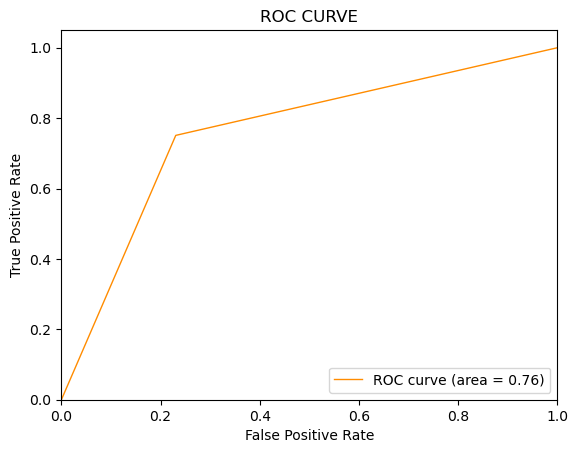

CPU times: user 1h 37min, sys: 8.43 s, total: 1h 37min 8s
Wall time: 24min 41s


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [228]:
%%time
RFmodel = RandomForestClassifier(
    n_jobs=-1
)
RFmodel.fit(X_train_1_gram, y_train)
y_pred5 = RFmodel.predict(X_test_1_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred5)
metrics_dict = model_Evaluate(RFmodel, fpr, tpr, y_test, y_pred5)

results_df = results_df.append({'Model': 'RandomForestClassifier2', 'Dataset': 'X_train_1_gram', **metrics_dict}, ignore_index=True)

In [229]:
%%time
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_2_gram, y_train)
y_pred1 = BNBmodel.predict(X_test_2_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
metrics_dict = model_Evaluate(BNBmodel, fpr, tpr, y_test, y_pred1)

results_df = results_df.append({'Model': 'BernoulliNB', 'Dataset': 'X_train_2_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.73      0.66      0.69     25052
           1       0.69      0.75      0.72     24948

    accuracy                           0.70     50000
   macro avg       0.71      0.71      0.70     50000
weighted avg       0.71      0.70      0.70     50000



CPU times: user 1.14 s, sys: 200 ms, total: 1.34 s
Wall time: 971 ms


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [230]:
%%time
SVCmodel = LinearSVC(dual='auto')
SVCmodel.fit(X_train_2_gram, y_train)
y_pred2 = SVCmodel.predict(X_test_2_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
metrics_dict = model_Evaluate(SVCmodel, fpr, tpr, y_test, y_pred2)

results_df = results_df.append({'Model': 'LinearSVC', 'Dataset': 'X_train_2_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.73      0.64      0.68     25052
           1       0.68      0.76      0.72     24948

    accuracy                           0.70     50000
   macro avg       0.70      0.70      0.70     50000
weighted avg       0.70      0.70      0.70     50000



CPU times: user 3.48 s, sys: 230 ms, total: 3.71 s
Wall time: 3.33 s


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [231]:
%%time
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train_2_gram, y_train)
y_pred3 = LRmodel.predict(X_test_2_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
metrics_dict = model_Evaluate(LRmodel, fpr, tpr, y_test, y_pred3)

results_df = results_df.append({'Model': 'LogisticRegression', 'Dataset': 'X_train_2_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.74      0.64      0.68     25052
           1       0.68      0.77      0.72     24948

    accuracy                           0.71     50000
   macro avg       0.71      0.71      0.70     50000
weighted avg       0.71      0.71      0.70     50000



CPU times: user 929 ms, sys: 589 ms, total: 1.52 s
Wall time: 16.8 s


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


              precision    recall  f1-score   support

           0       0.62      0.80      0.70     25052
           1       0.72      0.50      0.59     24948

    accuracy                           0.65     50000
   macro avg       0.67      0.65      0.64     50000
weighted avg       0.67      0.65      0.64     50000



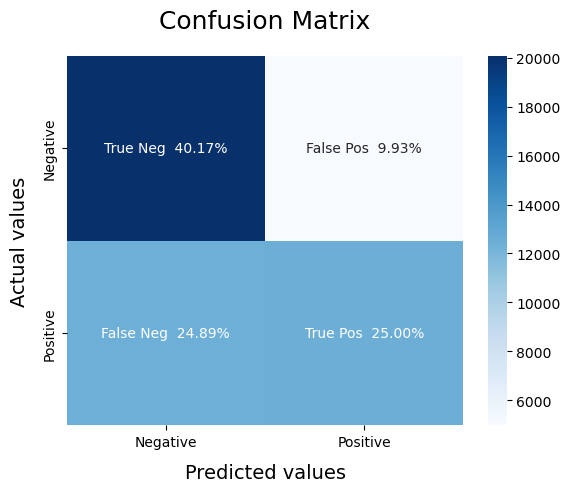

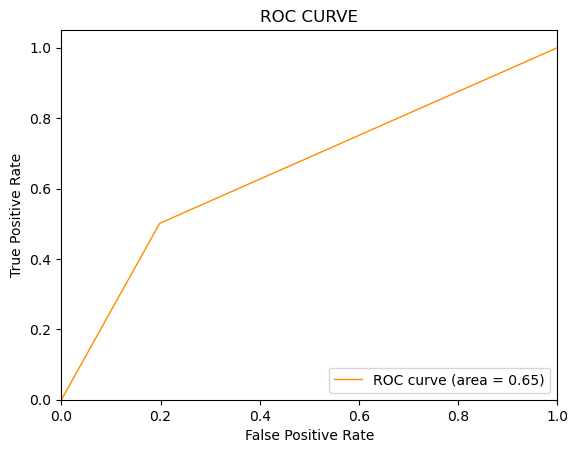

CPU times: user 9h 55min 21s, sys: 42 s, total: 9h 56min 3s
Wall time: 2h 31min 35s


<timed exec>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [232]:
%%time
RFmodel = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=49,
    n_jobs=-1
)
RFmodel.fit(X_train_2_gram, y_train)
y_pred4 = RFmodel.predict(X_test_2_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred4)
metrics_dict = model_Evaluate(RFmodel, fpr, tpr, y_test, y_pred4)

results_df = results_df.append({'Model': 'RandomForestClassifier1', 'Dataset': 'X_train_2_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.62      0.80      0.70     25052
           1       0.71      0.50      0.59     24948

    accuracy                           0.65     50000
   macro avg       0.66      0.65      0.64     50000
weighted avg       0.66      0.65      0.64     50000



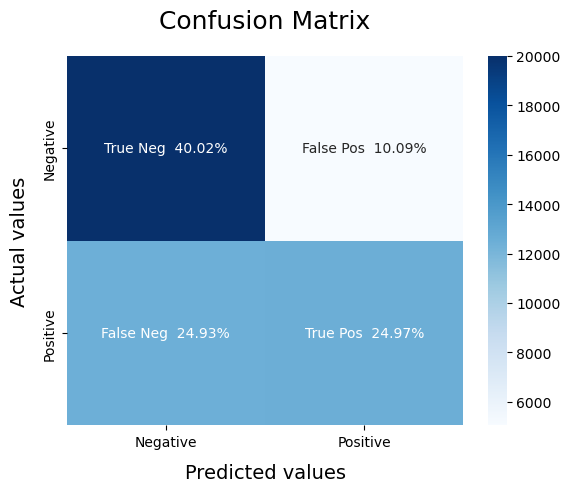

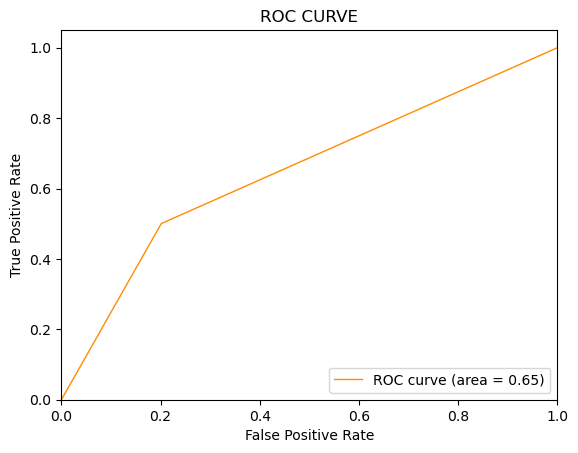

CPU times: user 9h 58min 56s, sys: 41.3 s, total: 9h 59min 38s
Wall time: 2h 31min 48s


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [233]:
%%time
RFmodel = RandomForestClassifier(
    n_jobs=-1
)
RFmodel.fit(X_train_2_gram, y_train)
y_pred5 = RFmodel.predict(X_test_2_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred5)
metrics_dict = model_Evaluate(RFmodel, fpr, tpr, y_test, y_pred5)

results_df = results_df.append({'Model': 'RandomForestClassifier2', 'Dataset': 'X_train_2_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.74      0.23      0.36     25052
           1       0.54      0.92      0.68     24948

    accuracy                           0.58     50000
   macro avg       0.64      0.58      0.52     50000
weighted avg       0.64      0.58      0.52     50000



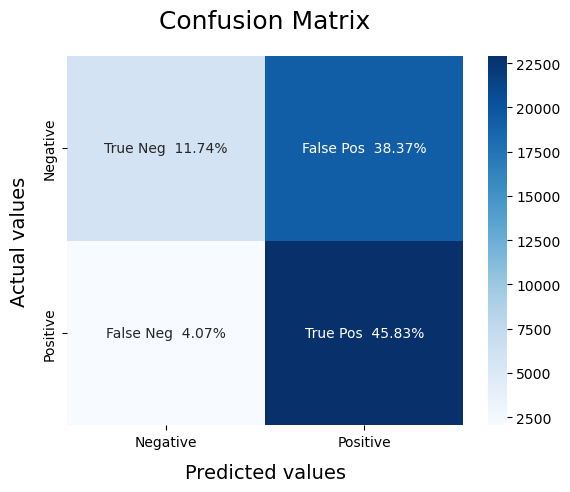

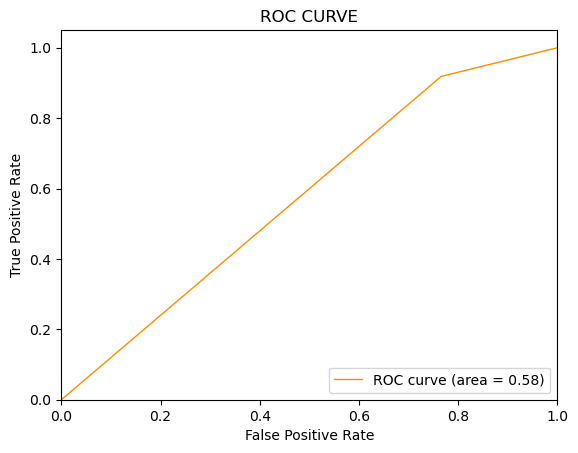

CPU times: user 826 ms, sys: 200 ms, total: 1.03 s
Wall time: 651 ms


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [234]:
%%time
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_3_gram, y_train)
y_pred1 = BNBmodel.predict(X_test_3_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
metrics_dict = model_Evaluate(BNBmodel, fpr, tpr, y_test, y_pred1)

results_df = results_df.append({'Model': 'BernoulliNB', 'Dataset': 'X_train_3_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.73      0.24      0.36     25052
           1       0.54      0.91      0.68     24948

    accuracy                           0.58     50000
   macro avg       0.64      0.58      0.52     50000
weighted avg       0.64      0.58      0.52     50000



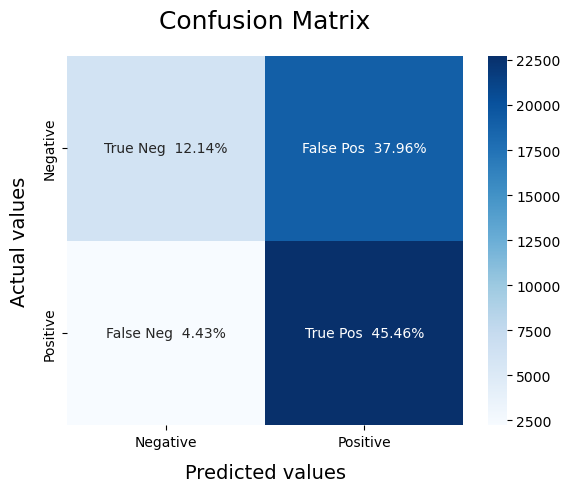

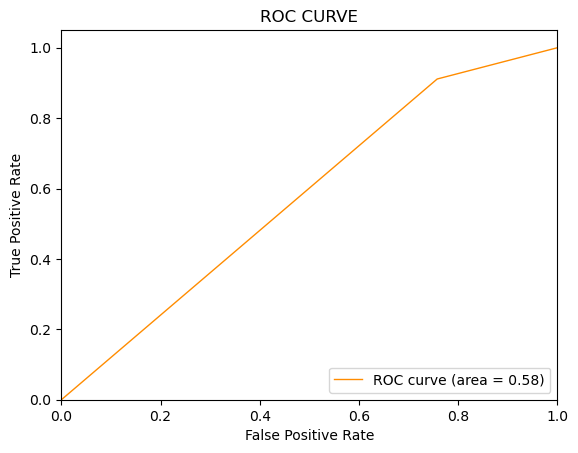

CPU times: user 3.17 s, sys: 210 ms, total: 3.38 s
Wall time: 3.01 s


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [235]:
%%time
SVCmodel = LinearSVC(dual='auto')
SVCmodel.fit(X_train_3_gram, y_train)
y_pred2 = SVCmodel.predict(X_test_3_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
metrics_dict = model_Evaluate(SVCmodel, fpr, tpr, y_test, y_pred2)

results_df = results_df.append({'Model': 'LinearSVC', 'Dataset': 'X_train_3_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.73      0.24      0.36     25052
           1       0.55      0.91      0.68     24948

    accuracy                           0.58     50000
   macro avg       0.64      0.58      0.52     50000
weighted avg       0.64      0.58      0.52     50000



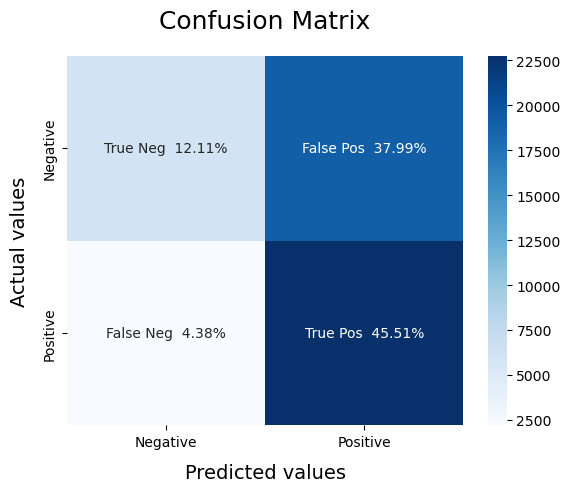

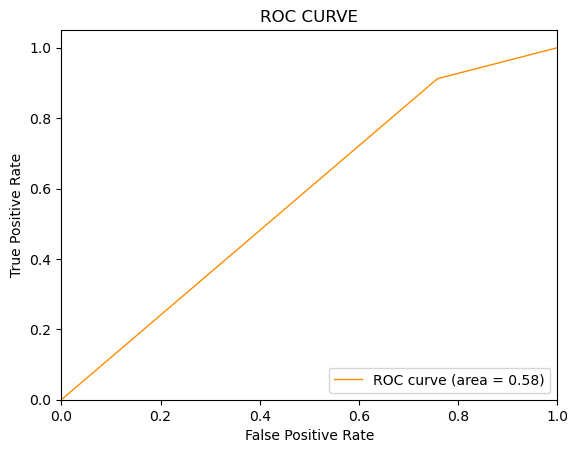

CPU times: user 1.35 s, sys: 659 ms, total: 2.01 s
Wall time: 15.6 s


<timed exec>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [236]:
%%time
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train_3_gram, y_train)
y_pred3 = LRmodel.predict(X_test_3_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
metrics_dict = model_Evaluate(LRmodel, fpr, tpr, y_test, y_pred3)

results_df = results_df.append({'Model': 'LogisticRegression', 'Dataset': 'X_train_3_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.53      0.93      0.67     25052
           1       0.69      0.16      0.26     24948

    accuracy                           0.54     50000
   macro avg       0.61      0.54      0.46     50000
weighted avg       0.61      0.54      0.46     50000



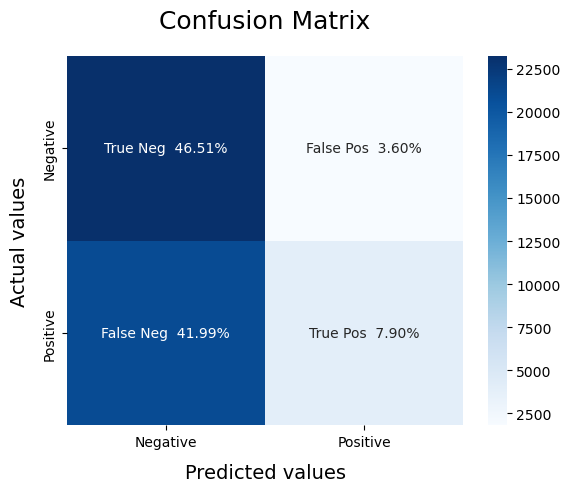

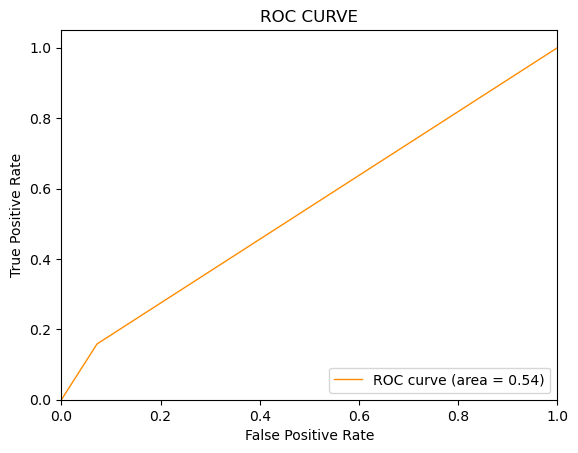

CPU times: user 20h 20min 33s, sys: 1min 25s, total: 20h 21min 58s
Wall time: 5h 8min 37s


<timed exec>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [237]:
%%time
RFmodel = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=49,
    n_jobs=-1
)
RFmodel.fit(X_train_3_gram, y_train)
y_pred4 = RFmodel.predict(X_test_3_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred4)
metrics_dict = model_Evaluate(RFmodel, fpr, tpr, y_test, y_pred4)

results_df = results_df.append({'Model': 'RandomForestClassifier1', 'Dataset': 'X_train_3_gram', **metrics_dict}, ignore_index=True)

              precision    recall  f1-score   support

           0       0.53      0.93      0.67     25052
           1       0.69      0.16      0.26     24948

    accuracy                           0.54     50000
   macro avg       0.61      0.54      0.46     50000
weighted avg       0.61      0.54      0.46     50000



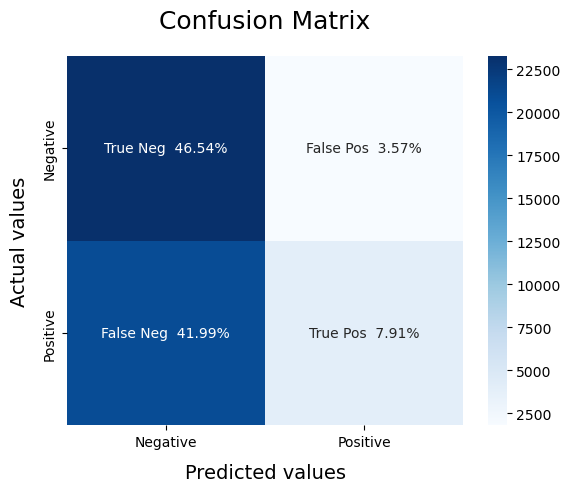

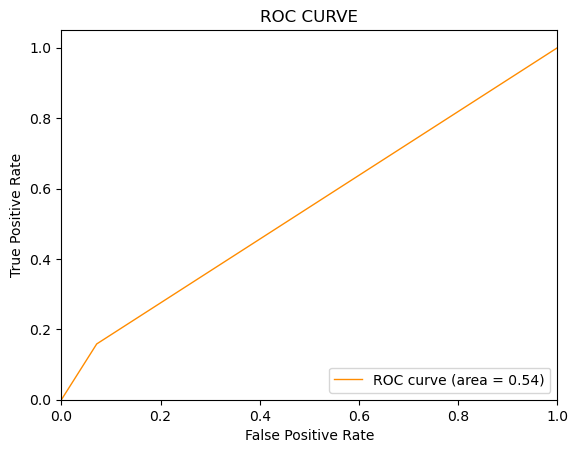

CPU times: user 20h 2min 26s, sys: 1min 31s, total: 20h 3min 58s
Wall time: 5h 4min 42s


<timed exec>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [238]:
%%time
RFmodel = RandomForestClassifier(
    n_jobs=-1
)
RFmodel.fit(X_train_3_gram, y_train)
y_pred5 = RFmodel.predict(X_test_3_gram)

fpr, tpr, thresholds = roc_curve(y_test, y_pred5)
metrics_dict = model_Evaluate(RFmodel, fpr, tpr, y_test, y_pred5)

results_df = results_df.append({'Model': 'RandomForestClassifier2', 'Dataset': 'X_train_3_gram', **metrics_dict}, ignore_index=True)

In [239]:
results_df.to_csv('../data/results/evaluation_results.csv', index=False)
display(results_df)

Model           Dataset  Accuracy  Precision    Recall  \
0               BernoulliNB  X_train_1_3_gram   0.76846   0.770482  0.763348   
1                 LinearSVC  X_train_1_3_gram   0.78078   0.792578  0.759380   
2        LogisticRegression  X_train_1_3_gram   0.77838   0.786047  0.763709   
3   RandomForestClassifier1  X_train_1_3_gram   0.75980   0.770488  0.738616   
4   RandomForestClassifier2  X_train_1_3_gram   0.76032   0.769993  0.740981   
5               BernoulliNB  X_train_1_2_gram   0.76840   0.779105  0.747876   
6                 LinearSVC  X_train_1_2_gram   0.77926   0.782457  0.772326   
7        LogisticRegression  X_train_1_2_gram   0.78084   0.781037  0.779221   
8   RandomForestClassifier1  X_train_1_2_gram   0.76362   0.769423  0.751443   
9   RandomForestClassifier2  X_train_1_2_gram   0.76268   0.770066  0.747595   
10              BernoulliNB  X_train_2_3_gram   0.70384   0.680710  0.765512   
11                LinearSVC  X_train_2_3_gram   0.70354   0.682163  0.759901   
12       LogisticRegression  X_train_2_3_gram   0.70526   0.680171  0.772567   
13  RandomForestClassifier1  X_train_2_3_gram   0.64940   0.717028  0.491182   
14  RandomForestClassifier2  X_train_2_3_gram   0.64936   0.715081  0.494148   
15              BernoulliNB    X_train_1_gram   0.75908   0.776156  0.726752   
16                LinearSVC    X_train_1_gram   0.76100   0.757713  0.765913   
17       LogisticRegression    X_train_1_gram   0.77096   0.763347  0.784031   
18  RandomForestClassifier1    X_train_1_gram   0.76136   0.765438  0.752245   
19  RandomForestClassifier2    X_train_1_gram   0.76022   0.764351  0.750962   
20              BernoulliNB    X_train_2_gram   0.70500   0.686599  0.752044   
21                LinearSVC    X_train_2_gram   0.69960   0.678049  0.757736   
22       LogisticRegression    X_train_2_gram   0.70522   0.679907  0.773248   
23  RandomForestClassifier1    X_train_2_gram   0.65176   0.715733  0.501082   
24  RandomForestClassifier2    X_train_2_gram   0.64984   0.712232  0.500401   
25              BernoulliNB    X_train_3_gram   0.57566   0.544314  0.918470   
26                LinearSVC    X_train_3_gram   0.57606   0.544964  0.911135   
27       LogisticRegression    X_train_3_gram   0.57622   0.545015  0.912137   
28  RandomForestClassifier1    X_train_3_gram   0.54410   0.687185  0.158409   
29  RandomForestClassifier2    X_train_3_gram   0.54444   0.689156  0.158450   

    F1 Score       AUC  
0   0.766898  0.768449  
1   0.775624  0.780736  
2   0.774717  0.778350  
3   0.754216  0.759756  
4   0.755209  0.760280  
5   0.763171  0.768357  
6   0.777359  0.779246  
7   0.780128  0.780837  
8   0.760327  0.763595  
9   0.758664  0.762649  
10  0.720625  0.703968  
11  0.718937  0.703657  
12  0.723431  0.705400  
13  0.582996  0.649072  
14  0.584432  0.649038  
15  0.750642  0.759013  
16  0.761791  0.761010  
17  0.773551  0.770987  
18  0.758784  0.761341  
19  0.757597  0.760201  
20  0.717833  0.705098  
21  0.715681  0.699721  
22  0.723580  0.705361  
23  0.589475  0.651447  
24  0.587814  0.649530  
25  0.683541  0.576372  
26  0.682008  0.576756  
27  0.682329  0.576917  
28  0.257468  0.543299  
29  0.257659  0.543639

In [241]:
display(results_df.sort_values(by='Accuracy', ascending=False))

Model           Dataset  Accuracy  Precision    Recall  \
7        LogisticRegression  X_train_1_2_gram   0.78084   0.781037  0.779221   
1                 LinearSVC  X_train_1_3_gram   0.78078   0.792578  0.759380   
6                 LinearSVC  X_train_1_2_gram   0.77926   0.782457  0.772326   
2        LogisticRegression  X_train_1_3_gram   0.77838   0.786047  0.763709   
17       LogisticRegression    X_train_1_gram   0.77096   0.763347  0.784031   
0               BernoulliNB  X_train_1_3_gram   0.76846   0.770482  0.763348   
5               BernoulliNB  X_train_1_2_gram   0.76840   0.779105  0.747876   
8   RandomForestClassifier1  X_train_1_2_gram   0.76362   0.769423  0.751443   
9   RandomForestClassifier2  X_train_1_2_gram   0.76268   0.770066  0.747595   
18  RandomForestClassifier1    X_train_1_gram   0.76136   0.765438  0.752245   
16                LinearSVC    X_train_1_gram   0.76100   0.757713  0.765913   
4   RandomForestClassifier2  X_train_1_3_gram   0.76032   0.769993  0.740981   
19  RandomForestClassifier2    X_train_1_gram   0.76022   0.764351  0.750962   
3   RandomForestClassifier1  X_train_1_3_gram   0.75980   0.770488  0.738616   
15              BernoulliNB    X_train_1_gram   0.75908   0.776156  0.726752   
12       LogisticRegression  X_train_2_3_gram   0.70526   0.680171  0.772567   
22       LogisticRegression    X_train_2_gram   0.70522   0.679907  0.773248   
20              BernoulliNB    X_train_2_gram   0.70500   0.686599  0.752044   
10              BernoulliNB  X_train_2_3_gram   0.70384   0.680710  0.765512   
11                LinearSVC  X_train_2_3_gram   0.70354   0.682163  0.759901   
21                LinearSVC    X_train_2_gram   0.69960   0.678049  0.757736   
23  RandomForestClassifier1    X_train_2_gram   0.65176   0.715733  0.501082   
24  RandomForestClassifier2    X_train_2_gram   0.64984   0.712232  0.500401   
13  RandomForestClassifier1  X_train_2_3_gram   0.64940   0.717028  0.491182   
14  RandomForestClassifier2  X_train_2_3_gram   0.64936   0.715081  0.494148   
27       LogisticRegression    X_train_3_gram   0.57622   0.545015  0.912137   
26                LinearSVC    X_train_3_gram   0.57606   0.544964  0.911135   
25              BernoulliNB    X_train_3_gram   0.57566   0.544314  0.918470   
29  RandomForestClassifier2    X_train_3_gram   0.54444   0.689156  0.158450   
28  RandomForestClassifier1    X_train_3_gram   0.54410   0.687185  0.158409   

    F1 Score       AUC  
7   0.780128  0.780837  
1   0.775624  0.780736  
6   0.777359  0.779246  
2   0.774717  0.778350  
17  0.773551  0.770987  
0   0.766898  0.768449  
5   0.763171  0.768357  
8   0.760327  0.763595  
9   0.758664  0.762649  
18  0.758784  0.761341  
16  0.761791  0.761010  
4   0.755209  0.760280  
19  0.757597  0.760201  
3   0.754216  0.759756  
15  0.750642  0.759013  
12  0.723431  0.705400  
22  0.723580  0.705361  
20  0.717833  0.705098  
10  0.720625  0.703968  
11  0.718937  0.703657  
21  0.715681  0.699721  
23  0.589475  0.651447  
24  0.587814  0.649530  
13  0.582996  0.649072  
14  0.584432  0.649038  
27  0.682329  0.576917  
26  0.682008  0.576756  
25  0.683541  0.576372  
29  0.257659  0.543639  
28  0.257468  0.543299